In [1]:
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
from pprint import pprint

SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)

In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 75.9 ms, sys: 19.8 ms, total: 95.7 ms
Wall time: 95.7 ms
(8652, 4) docs shape


,id,titulo,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9
1,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8
2,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9
3,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12
4,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7
5,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",14
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,"[vle, base, dynam, simul, trickl, bed, reactor...",13
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,"[solubl, behavior, gamma, valerolacton, tetrad...",9
9,116792663386170,Removal of amoxicillin from water by adsorptio...,"[remov, amoxicillin, water, adsorpt, onto, act...",25


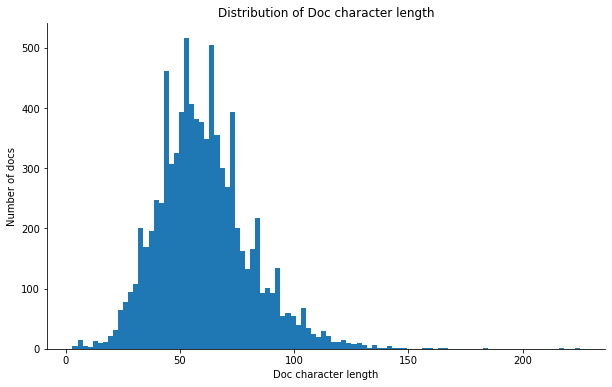

In [3]:
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df.clean]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Doc character length')
plt.ylabel('Number of docs')
plt.xlabel('Doc character length')
sns.despine()

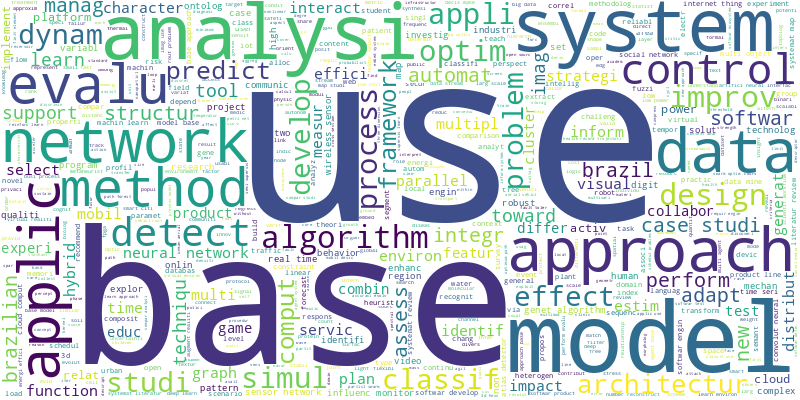

In [4]:
long_string = ' '.join(list(df['clean'].values))

wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color="white",
                max_words=5000,
                contour_width=3,
                contour_color='steelblue'
                ).generate(long_string)

wordcloud.to_image()

In [5]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in the docs"))
fig.show()

In [6]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['clean'], 20)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 bigrams in the docs"))
fig.show()

In [7]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['clean'], 20)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

fig = go.Figure([go.Bar(x=df4['trigram'], y=df4['count'])])
fig.update_layout(title=go.layout.Title(text="Top 20 trigrams in the docs"))
fig.show()

In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(df['clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
3      -10.878068   10.538728       1        1  8.118852
16     -60.884026  -75.591820       2        1  6.814431
2       -2.336119  -53.289074       3        1  6.696247
7      -61.385319  -12.914634       4        1  6.036531
6      -28.737743  126.296997       5        1  5.842459
12       1.066606 -123.552811       6        1  5.819817
15      45.140720   -7.947869       7        1  5.781610
13    -140.795975  -98.530548       8        1  5.724619
10      61.531681  -83.240562       9        1  5.420837
11     -72.563057 -140.396881      10        1  5.313963
8       15.984491   63.578186      11        1  5.090863
0     -160.851624   68.945145      12        1  4.854846
4       85.961830   51.922935      13        1  4.589129
9      -99.020836  109.936348      14        1  4.524164
17    -176.764130   -8.681684      15        1  3.852334
5     -117.189880  -37.420200      16        1  3.535998
19     108.829918  -22.946203      17        1  3.294219
1       47.588097  121.934814      18        1  3.210347
14    -106.467834   30.176889      19        1  3.096289
18     -50.613804   59.328842      20        1  2.382447, topic_info=           Term        Freq        Total Category  logprob  loglift
698        data  547.000000   547.000000  Default  30.0000  30.0000
2650    softwar  402.000000   402.000000  Default  29.0000  29.0000
1871    network  705.000000   705.000000  Default  28.0000  28.0000
85    algorithm  419.000000   419.000000  Default  27.0000  27.0000
146    approach  496.000000   496.000000  Default  26.0000  26.0000
...         ...         ...          ...      ...      ...      ...
1705      metal   10.553355    11.461449  Topic20  -5.0109   3.6545
2030   particip   10.156142    11.064235  Topic20  -5.0493   3.6514
1453      invas   10.062484    10.970584  Topic20  -5.0585   3.6506
1006     experi   72.370519   119.687063  Topic20  -3.0856   3.2340
245        base   11.482210  1131.042329  Topic20  -4.9266  -0.8531

[794 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
16       19  0.958440   absolut
23        8  0.987244    access
28       14  0.956066  accuraci
38        4  0.991507     activ
41        1  0.126268     adapt
...     ...       ...       ...
3121      4  0.967585      wind
3125      4  0.992539  wireless
3131     19  0.966362      work
3132     20  0.975699  workflow
3135      4  0.944887     world

[857 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 17, 3, 8, 7, 13, 16, 14, 11, 12, 9, 1, 5, 10, 18, 6, 20, 2, 15, 19])

In [9]:
# print log-likelihood
print("Log likelihood: ", lda_model.score(data_vectorized))

# print perplexity
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log likelihood:  -508245.4894076752
Perplexity:  2094.4453768508793


In [10]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['W'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['T'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19
T0,brazil,architectur,impact,complex,servic,environ,collabor,manag,integr,digit,chang,water,autonom,analysi,field,emerg,virtual,cognit,logic,propos
T1,low,virtual,game,knowledg,cost,recommend,heterogen,user,detector,natur,condit,induc,error,realiti,configur,studi,reason,critic,radiat,stress
T2,model,base,assess,effect,predict,network,qualiti,industri,orient,analysi,deep,solut,program,environ,internet,alloc,develop,control,transform,gene
T3,process,evalu,engin,review,distribut,base,learn,educ,use,systemat,studi,approach,linear,platform,requir,languag,manag,health,monitor,design
T4,dynam,measur,machin,base,featur,select,code,theori,build,robust,similar,tempor,memori,properti,connect,gpu,determin,direct,exploit,locat
T5,map,techniqu,plan,combin,segment,dimension,fault,urban,diagnosi,traffic,risk,topolog,toler,fast,systemat,free,descript,usabl,storag,lesion
T6,applic,analysi,graph,hybrid,use,awar,support,estim,compar,context,adapt,search,mobil,investig,devic,model,autom,forecast,respons,web
T7,data,simul,network,use,sensor,framework,model,activ,open,wireless,experiment,stream,sourc,survey,project,relat,analyt,defin,uncertainti,evolut
T8,studi,case,automat,strategi,identif,tool,heurist,behavior,novel,brazilian,challeng,differ,evalu,signal,communiti,ecosystem,method,public,binari,descriptor
T9,multi,detect,object,inform,base,agent,genom,sequenc,communic,event,type,depend,differ,aspect,hierarch,target,cancer,frequenc,execut,face
